<a href="https://colab.research.google.com/github/khairulomar/Melbourne_pedestrian/blob/master/Melbourne_pedestrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import csv
import requests
import progressbar

dates_list = ['05-02-2020']
dates_df_list = []
# Create progress bar to track
pbar = progressbar.ProgressBar()
for date in pbar(dates_list):
    day, month, year = date[0:2], date[3:5], date[6:10]
    hours = []
    # Scrape data from daily csv download link. Repeat for each date.
    raw = requests.get(f'https://compedapi.herokuapp.com/api/bydatecsv/{date}').text
    raw = raw.replace('N/A','0')
    df = pd.DataFrame(columns=list(range(25)))
    # Line break before passing to csv conversion
    reader = csv.reader(raw.split('\n'), delimiter=',')
    for row in reader:
        # Skip non-data rows
        if len(row) < 2:
            continue
        # Stop at end of record (Total)    
        elif row[0] == 'Total':
            break
        # Insert only relevant records into df    
        else:
            df.loc[len(df)] = row
    df.columns = df.iloc[0]
    df = df.drop(0)
    # Combine hours in columns with date info
    for hour in list(range(24)):
        if hour < 10: hour = str(f'0{hour}')
        h = f'{year}-{month}-{day}-{hour}'
        pd.to_datetime(year,)
        hours.append(h)
    col_names = ['Sensor'] + hours
    col_names
    df.columns = col_names
# Reshape df from time in columns to time in rows
df = df.T
#df2.index = pd.to_datetime(df2.index)
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = pd.DataFrame(df.stack())
df = df.reset_index()
df = df.rename(columns={'level_0':'Time',0:'Count'})

df.tail(5)

100% (1 of 1) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


,Time,Sensor,Count
1435,2020-02-05-23,RMIT Building 14,86
1436,2020-02-05-23,380 Elizabeth St,373
1437,2020-02-05-23,La Trobe St (North),69
1438,2020-02-05-23,231 Bourke St,0
1439,2020-02-05-23,Royal Pde - Grattan St,12


In [0]:
import pandas as pd
from sodapy import Socrata

client = Socrata('data.melbourne.vic.gov.au',
                 'rU9dviaJKpt9U9Mk9aPFFOIvS',
                 'khairul@yahoo.com',
                 'KhairulMaps2019&')

# To select multiple month, loop over list.
# Data for a given month only available once month is over.
results = client.get("b2ak-trbp", day='Monday', time=12, limit=100000)

dfraw = pd.DataFrame.from_records(results)
display(len(dfraw))
display(dfraw.head())

17822

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2891212,2019-11-04T12:00:00.000,2019,November,4,Monday,12,4,Town Hall (West),4535
1,2891213,2019-11-04T12:00:00.000,2019,November,4,Monday,12,17,Collins Place (South),1145
2,2891214,2019-11-04T12:00:00.000,2019,November,4,Monday,12,18,Collins Place (North),421
3,2891215,2019-11-04T12:00:00.000,2019,November,4,Monday,12,53,Collins St (North),2570
4,2891216,2019-11-04T12:00:00.000,2019,November,4,Monday,12,2,Bourke Street Mall (South),5227


In [0]:
dfraw.columns

Index(['id', 'date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id',
       'sensor_name', 'hourly_counts'],
      dtype='object')

In [0]:
import datetime as dt 
df = dfraw.copy()
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['year'] = df['year'].astype('int')
df['hourly_counts'] = df['hourly_counts'].astype('int')
df['sensor'] = df['sensor_id'].map(lambda row: '0'+str(row) if int(row)<10 else row) + " : " + df['sensor_name']
df['sensor_id'] = df['sensor_id'].astype('int')
df.dtypes

id                       object
date_time        datetime64[ns]
year                      int64
month                    object
mdate                    object
day                      object
time                     object
sensor_id                 int64
sensor_name              object
hourly_counts             int64
date                     object
sensor                   object
dtype: object

In [0]:
dfplot = df[df['year'] > 2013][['date','sensor','hourly_counts']]
dfplot.head()

,date,sensor,hourly_counts
0,2019-11-04,04 : Town Hall (West),4535
1,2019-11-04,17 : Collins Place (South),1145
2,2019-11-04,18 : Collins Place (North),421
3,2019-11-04,53 : Collins St (North),2570
4,2019-11-04,02 : Bourke Street Mall (South),5227


In [0]:
import numpy as np
table = pd.pivot_table(dfplot, values='hourly_counts', index='date',
                       columns='sensor', aggfunc=np.sum)
table.head()

sensor,01 : Bourke Street Mall (North),02 : Bourke Street Mall (South),03 : Melbourne Central,04 : Town Hall (West),05 : Princes Bridge,06 : Flinders Street Station Underpass,07 : Birrarung Marr,08 : Webb Bridge,09 : Southern Cross Station,10 : Victoria Point,11 : Waterfront City,12 : New Quay,13 : Flagstaff Station,14 : Sandridge Bridge,15 : State Library,16 : Australia on Collins,17 : Collins Place (South),18 : Collins Place (North),19 : Chinatown-Swanston St (North),20 : Chinatown-Lt Bourke St (South),21 : Bourke St-Russell St (West),22 : Flinders St-Elizabeth St (East),23 : Spencer St-Collins St (South),24 : Spencer St-Collins St (North),25 : Melbourne Convention Exhibition Centre,26 : QV Market-Elizabeth St (West),27 : QV Market-Peel St,28 : The Arts Centre,29 : St Kilda Rd-Alexandra Gardens,30 : Lonsdale St (South),31 : Lygon St (West),32 : City Square,33 : Flinders St-Spring St (West),34 : Flinders St-Spark La,35 : Southbank,36 : Queen St (West),37 : Lygon St (East),38 : Flinders St-Swanston St (West),39 : Alfred Place,40 : Lonsdale St-Spring St (West),41 : Flinders La-Swanston St (West),42 : Grattan St-Swanston St (West),43 : Monash Rd-Swanston St (West),44 : Tin Alley-Swanston St (West),45 : Little Collins St-Swanston St (East),46 : Pelham St (S),46 : Pelham St (South),47 : Melbourne Central-Elizabeth St (East),48 : QVM-Queen St (East),49 : QVM-Therry St (South),50 : Faraday St-Lygon St (West),51 : QVM-Franklin St (North),52 : Elizabeth St-Lonsdale St (South),53 : Collins St (North),54 : Lincoln-Swanston (West),54 : Lincoln-Swanston(West),55 : Elizabeth St-La Trobe St (East),56 : Lonsdale St - Elizabeth St (North),57 : Bourke St Bridge,58 : Bourke St - Spencer St (North),59 : Swanston St - RMIT Building 80,60 : Flinders La - Swanston St (West) Temp,60 : Flinders la - Swanston St (West) Temp,61 : Swanston St - RMIT Building 14,62 : La Trobe St (North),63 : 231 Bourke St,64 : Royal Pde-Grattan St
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-06,3155.0,3776.0,2515.0,3711.0,1718.0,1980.0,337.0,599.0,1042.0,282.0,183.0,338.0,817.0,624.0,1574.0,2544.0,1422.0,533.0,980.0,746.0,1192.0,2908.0,576.0,1771.0,864.0,1071.0,125.0,1430.0,746.0,898.0,508.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-13,3153.0,3683.0,1698.0,3465.0,1564.0,2076.0,638.0,608.0,1135.0,381.0,217.0,417.0,1171.0,565.0,1585.0,2616.0,1840.0,683.0,982.0,602.0,NaN,2923.0,665.0,1904.0,787.0,932.0,126.0,1138.0,766.0,858.0,624.0,1774.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-20,3316.0,3755.0,2173.0,3846.0,1820.0,2139.0,631.0,676.0,1108.0,309.0,220.0,398.0,1144.0,682.0,1646.0,2862.0,1617.0,692.0,919.0,674.0,1103.0,3096.0,625.0,1919.0,940.0,945.0,159.0,1454.0,804.0,949.0,481.0,2007.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-27,2017.0,1883.0,1383.0,2348.0,1455.0,868.0,474.0,141.0,109.0,55.0,155.0,273.0,69.0,269.0,1042.0,875.0,252.0,121.0,718.0,403.0,570.0,1786.0,96.0,609.0,617.0,414.0,53.0,1120.0,666.0,534.0,370.0,855.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-03,2119.0,3014.0,1783.0,2822.0,1220.0,1792.0,311.0,492.0,887.0,341.0,165.0,337.0,1062.0,484.0,1427.0,2028.0,1497.0,626.0,775.0,526.0,1168.0,2368.0,546.0,1824.0,675.0,942.0,152.0,1020.0,573.0,806.0,423.0,1450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


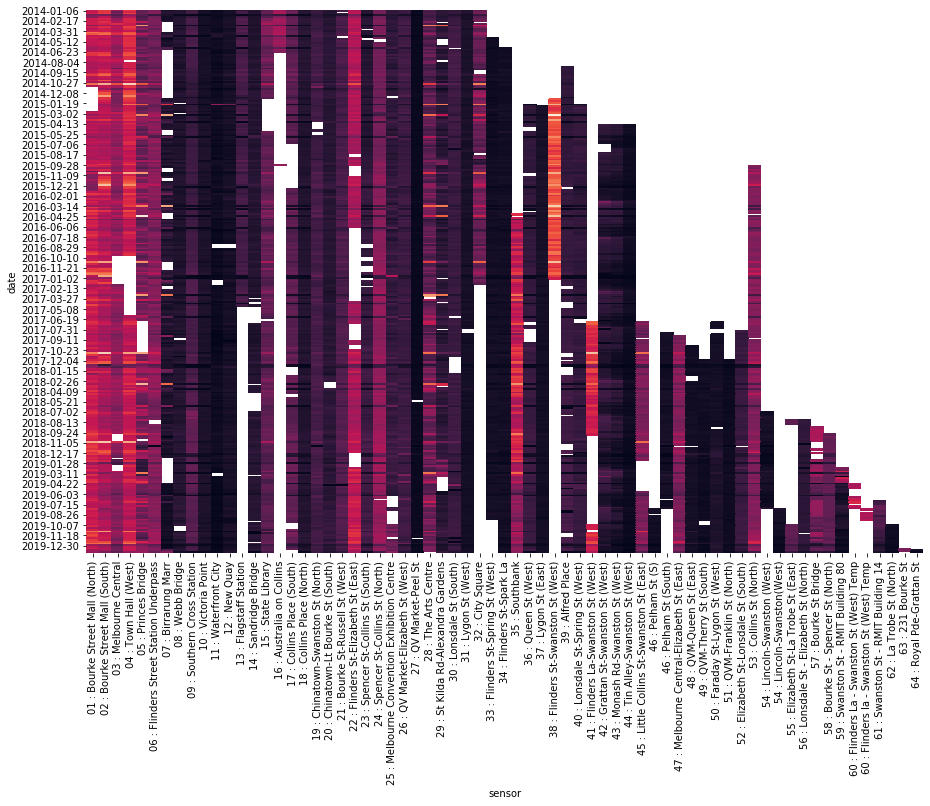

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(table, cbar=False)